In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import geopy.distance as gd
import math

from pymongo import MongoClient
cl = MongoClient()
db = cl['flights']

In [2]:
folder = "D:\Victor\OneDrive\Documents\Studie\Msc. Thesis\Code"
fname = "\output.csv"
fname_icao = "\output_icao.csv"
fin = folder+fname
fin_icao = folder+fname_icao

In [3]:
# df = pd.read_csv(fin, names=['ts', 'icao', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc', 'callsign'])
df_icao = pd.read_csv(fin_icao, names=['ts', 'icao', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc', 'callsign'])

In [4]:
def parallelize_on_icao(df_in, func):
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    print("Number of unique icaos: %d", len(df_in['icao'].unique()))
    df_processed = pd.concat(pool.map(func, [group for name, group in pd.groupby(df_in, by=['icao'])]))
    pool.close()
    pool.join()
    return df_processed

In [5]:
def hist_from_tuples(lst,mx=100):
    indices = np.arange(len(lst))
    count = [i[1] for i in lst]
    xlabels = [i[0] for i in lst]
    plt.bar(indices[:mx], count[:mx], color='b')
    plt.xticks(indices[:mx], xlabels[:mx], rotation='vertical')
    # plt.tight_layout()
    plt.show()

In [6]:
def separate_flights(icao, split_window=1800):
    icao = icao.reset_index(drop=True)
    icao['ts_diff'] = icao['ts'].diff()
    icao['ts_diff'].iloc[0] = 0
    icao['flight'] = np.nan
    ilist = [0]
    ilist.extend(icao.loc[icao['ts_diff'] > split_window].index.tolist())
    cnt = 1
    if len(ilist) > 1:
        for i in range(len(ilist)-1):
            icao['flight'].iloc[ilist[i]:ilist[i+1]] = cnt
            cnt = cnt + 1
        icao['flight'].iloc[ilist[-1]:] = cnt
    else:
        icao['flight'] = cnt
        
    icao = icao.drop(['ts_diff'],axis=1)
    icao['flight_count'] = icao['flight'].max()
    icao['flight_id'] = icao['icao'].astype(str)+'-'+icao['flight'].astype(int).astype(str)
    return icao

In [188]:
def create_flight_dict(df):
    dct = {}
    for name, g in df.groupby('flight_id'):
        fl_data = g[['ts', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc', 'callsign']]
        fl_data = fl_data.reset_index()
        dct[name] = {
            'flight_length': len(g),
            'icao': g['icao'].unique()[0],
            'flight_number': g['flight'].unique()[0],
            'flight_data': fl_data,
                }
    
    return dct

In [198]:
def save_flights_to_db(df, coll='raw_flights'):
    for name, g in df.groupby('flight_id'):
        fl_data = g[['ts', 'lat', 'lon', 'alt', 'spd', 'hdg', 'roc', 'callsign']]
        fl_data = fl_data.reset_index()
        dct = {
            'flight_length': len(g),
            'icao': g['icao'].unique()[0],
            'flight_number': g['flight'].unique()[0],
            'flight_data': fl_data.to_dict('list'),
                }
        db[coll].insert_one(dct)
    
    return dct

In [8]:
def add_coord_dist_to_flight(fl_df):
    fl_df.rolling(['lat', 'lon']).apply(gd.vincenty(coords_1, coords_2))

In [9]:
def plot_flight_coord(fl_df):
    plt.scatter(fl_df['lon'],fl_df['lat'], c=fl_df['alt'], s=1)

In [70]:
def initial_bearing(r):
    pointa = r['coords-1']
    pointb = r['coords']
    
    if all(isinstance(t, tuple) for t in [pointa, pointb]):
    
        lat1 = math.radians(pointa[0])
        lat2 = math.radians(pointb[0])

        diffLong = math.radians(pointb[1] - pointa[1])

        x = math.sin(diffLong) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
                * math.cos(lat2) * math.cos(diffLong))

        initial_bearing = math.atan2(x, y)
        initial_bearing = math.degrees(initial_bearing)
        compass_bearing = (initial_bearing + 360) % 360

        return compass_bearing
    else:
        return np.nan

In [11]:
def calc_dist(r):
    return gd.vincenty(r['coords-1'], r['coords']).m

In [184]:
def calc_dist_err(r):
    
    pointa = r['coords']
    pointb = r['proj_coord']
    
    R = 6378.1 #Radius of the Earth
    
    if all(isinstance(t, tuple) for t in [pointa, pointb]):
    
        (lon1,lat1) = pointa
        (lon2,lat2) = pointb
        
        [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]
    
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(sqrt(a), math.sqrt(1 - a))

        d = R * c
        
    return d*1000

In [12]:
def coord_diff(x):
    tp = tuple(np.subtract(x['coords-1'],x['coords']))
    x['lat_diff'] = tp[0]
    x['lon_diff'] = tp[1]
    return x

In [13]:
def enrich_flight_data(fl_df):
    fl_df = fl_df.sort_values(by='ts')
    fl_df['coords'] = list(zip(fl_df['lat'],fl_df['lon']))
    fl_df['ts_diff'] = fl_df['ts'].diff()
    fl_df['coords-1'] = fl_df['coords'].shift(1)
    fl_df['dst'] = fl_df.apply(calc_dist, axis=1)
    fl_df['bearing'] = fl_df.apply(initial_bearing, axis=1)
    fl_df['bearing_diff'] = fl_df['bearing'].diff()
    fl_df['bearing_cumsum'] = fl_df['bearing_diff'].cumsum()
    fl_df['avg_spd'] = (fl_df['dst']/fl_df['ts_diff'])*1.94384 #in knots
    fl_df = fl_df.apply(coord_diff, axis=1)
    return fl_df

In [148]:
def nominal_proj(fl_df, look_ahead_t=10000):
    
    proj_coord_lat = []
    proj_coord_lon = []
    
    for i,r in fl_df.iterrows():
        if i < 3:
            coord_start = (r['lat'], r['lon'])
            hdg_start = r['hdg']
            spd_start = r['spd']
            ts_start = r['ts']
            proj_coord_lat.extend([np.nan])
            proj_coord_lon.extend([np.nan])
        else:
            if ((r['ts'] - ts_start) < look_ahead_t):
                dst_start = (r['ts'] - ts_start)*(spd_start*0.514444)
                crd = find_coord_dst_hdg(coord_start, hdg_start, dst_start)
                proj_coord_lat.extend([crd[0]])
                proj_coord_lon.extend([crd[1]])
            else:
                proj_coord_lat.extend([np.nan])
                proj_coord_lon.extend([np.nan])
    
    fl_df['proj_lat'] = proj_coord_lat
    fl_df['proj_lon'] = proj_coord_lon
#     fl_df['proj_coord'] = list(zip(fl_df['proj_coord_lat'].values,fl_df['proj_coord_lon'].values))
    return fl_df

In [127]:
def find_coord_dst_hdg(coord1, hdg, dst):
    # https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing
    
    R = 6378.1 #Radius of the Earth
    hdg = radians(hdg) #Bearing is 90 degrees converted to radians.
    d = dst/1000 #Distance in km

    lat1 = math.radians(coord1[0]) #Current lat point converted to radians
    lon1 = math.radians(coord1[1]) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(hdg))

    lon2 = lon1 + math.atan2(math.sin(hdg)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return (lat2,lon2)

In [12]:
len(set(df.icao.unique()).difference(df_icao.icao.unique()))

24

In [14]:
df_icao = df_icao[df_icao['alt'] > 29000]
grps = df_icao.groupby(['icao'])
icao_lst = [(name, len(group)) for name, group in grps]
icao_lst.sort(key=lambda tup: tup[1], reverse=True)

In [191]:
df_icao_2 = df_icao.groupby(['icao']).apply(separate_flights)
# df_2 = df.groupby(['icao']).apply(separate_flights)

In [63]:
flight_dict = create_flight_dict(df_icao_2)

In [199]:
save_flights_to_db(df_icao_2)

{'_id': ObjectId('5a3a72b9ae2b087be4937b7f'),
 'flight_data': {'alt': [40000,
   40000,
   39975,
   39975,
   39975,
   39975,
   40000,
   40000,
   40000,
   39975,
   39975,
   39975,
   39975,
   39975,
   39975,
   40000,
   40000,
   40000,
   39975,
   39975,
   39975,
   39975,
   39975,
   39950,
   39875,
   39750,
   39650,
   39200,
   39125,
   38950,
   38750,
   38750,
   38700,
   38700,
   38575,
   38275,
   38225,
   38200,
   38200,
   38100,
   38050,
   37725,
   37675,
   37325,
   37275,
   37175,
   37050,
   36975,
   36850,
   36825,
   36775,
   36750,
   36725,
   36600,
   36575,
   36375,
   36325,
   36275,
   36125,
   36100,
   36050,
   35550,
   35475,
   35350,
   35300,
   35250,
   35225,
   35200,
   35200,
   35175,
   35050,
   34950,
   34975,
   34975,
   34975,
   35000,
   35000,
   34975,
   34975,
   34675,
   33750,
   33700,
   33650,
   33550,
   33325,
   32700,
   32175,
   32125,
   32075,
   32000,
   32000,
   32000,
   31975,
  

In [64]:
df_icao_2 = []
df_2 = []

In [25]:
len([k for k in flight_dict.keys() if (flight_dict[k]['flight_length'] > 3000)])

65

In [161]:
flight_dict_2 = {}
for k in flight_dict.keys():
    if flight_dict[k]['flight_length'] > 3000:
        flight_dict_2[k] = flight_dict[k]
        flight_dict_2[k]['flight_data'] = enrich_flight_data(flight_dict[k]['flight_data'])


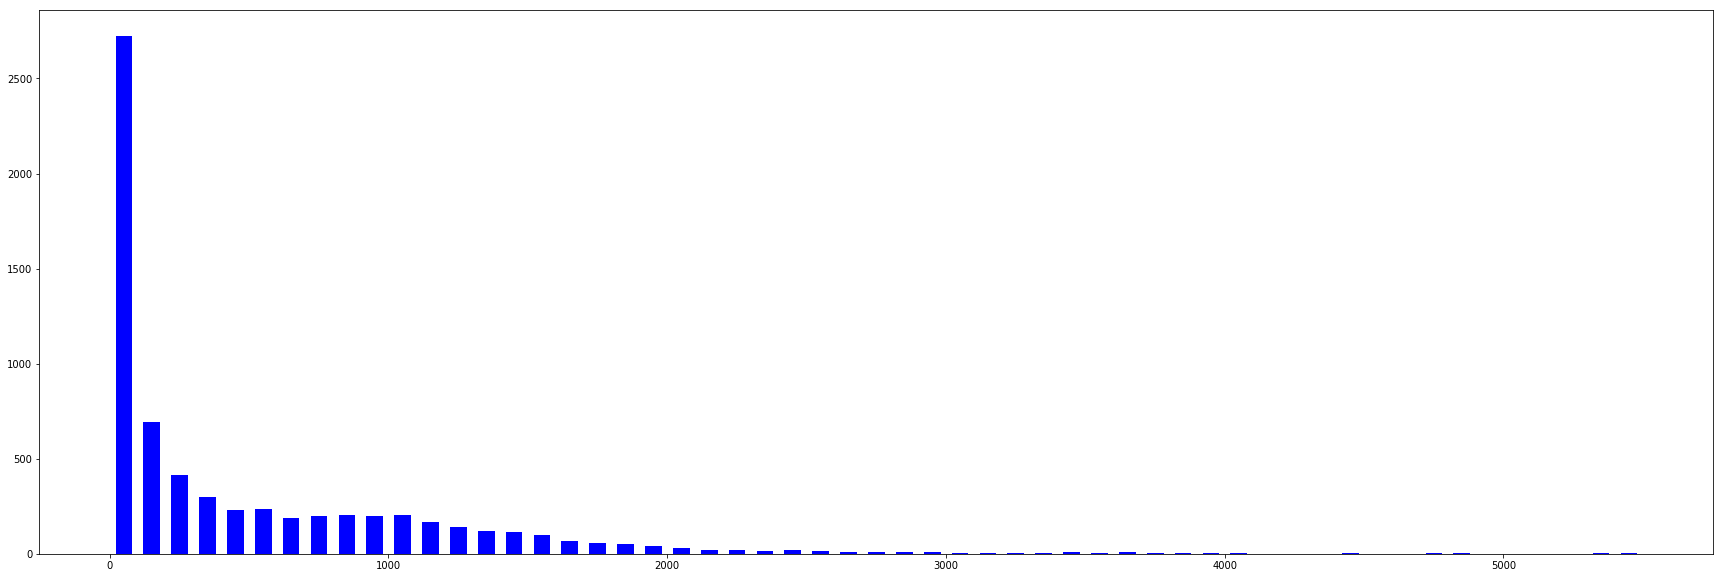

In [140]:
flight_lenghts = []
for k in flight_dict.keys():
    flight_lenghts.append((flight_dict[k]['flight_length'], k))

fl_len = [i[0] for i in flight_lenghts]

plt.figure(figsize=(30,10))
binwidth = 100
plt.hist(fl_len, bins=range(min(fl_len), max(fl_len) + binwidth, binwidth), facecolor='blue', rwidth=0.6)
plt.show()

In [42]:
for i in set(df_icao_2['flight_id'].unique()).difference(set(df_2['flight_id'].unique())):
    print(i + " " + str(flight_dict[i]['flight_length']))

4841D5-6 2170
3C6425-4 25


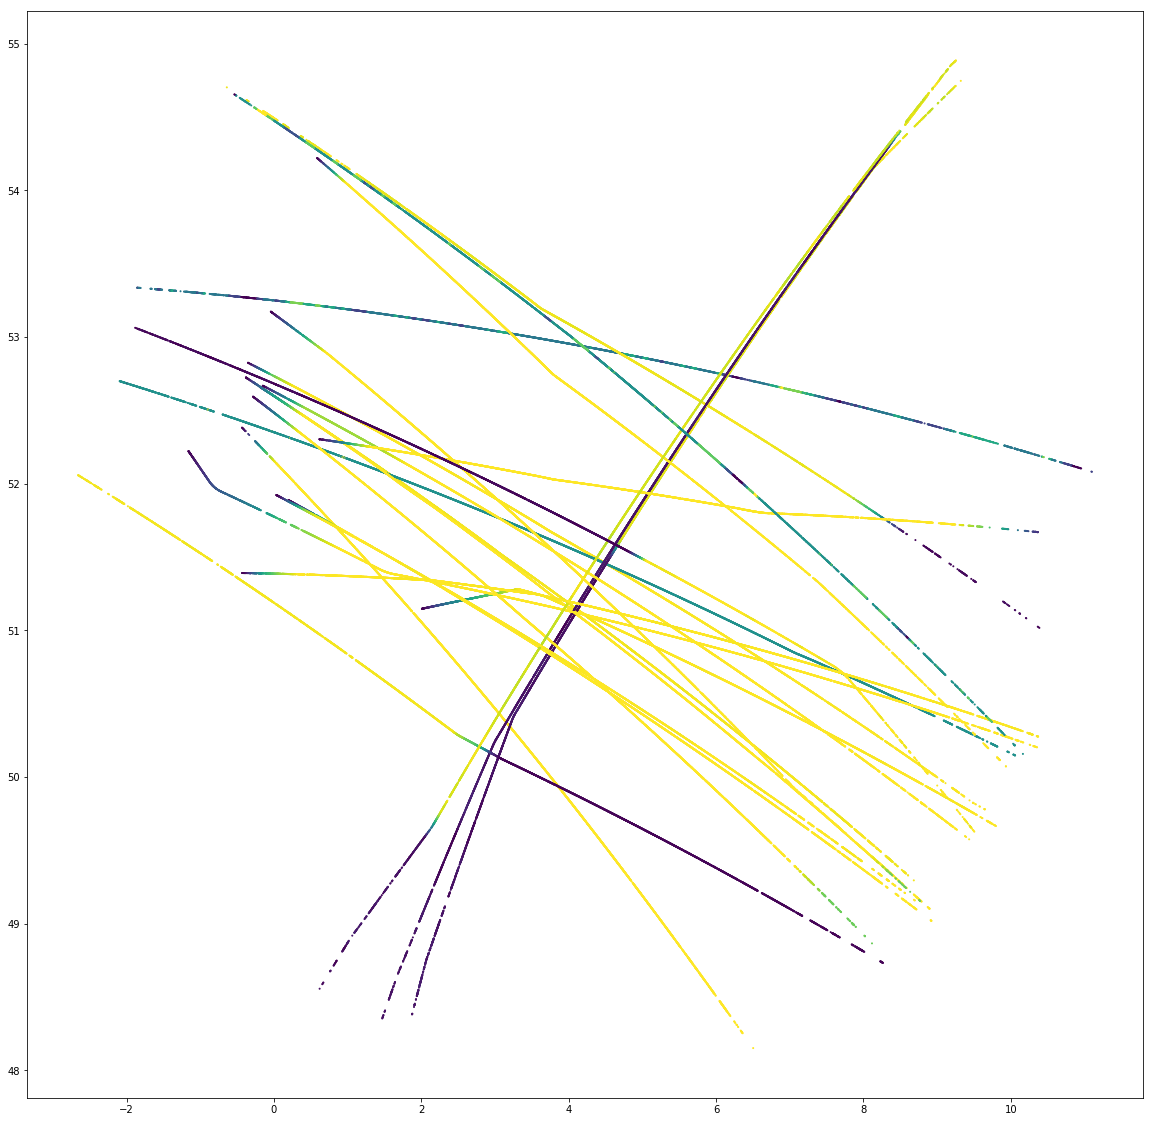

In [63]:
plt.figure(figsize=(20,20))
for fl in [flight_dict[k]['flight_data'] for k in flight_dict.keys() if 
           len(flight_dict[k]['flight_data'][flight_dict[k]['flight_data']['alt'] > 0]) > 4000]:
    plot_flight_coord(fl[fl['alt'] > 0])
plt.show()

In [27]:
tst = flight_dict_2[list(flight_dict_2.keys())[0]]['flight_data']
tst['bearing_cumsum'] = tst['bearing_diff'].cumsum()
tst['ts_cumsum'] = tst['ts_diff'].cumsum()

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(tst['ts_cumsum'],tst['bearing_diff'].values)
plt.show()

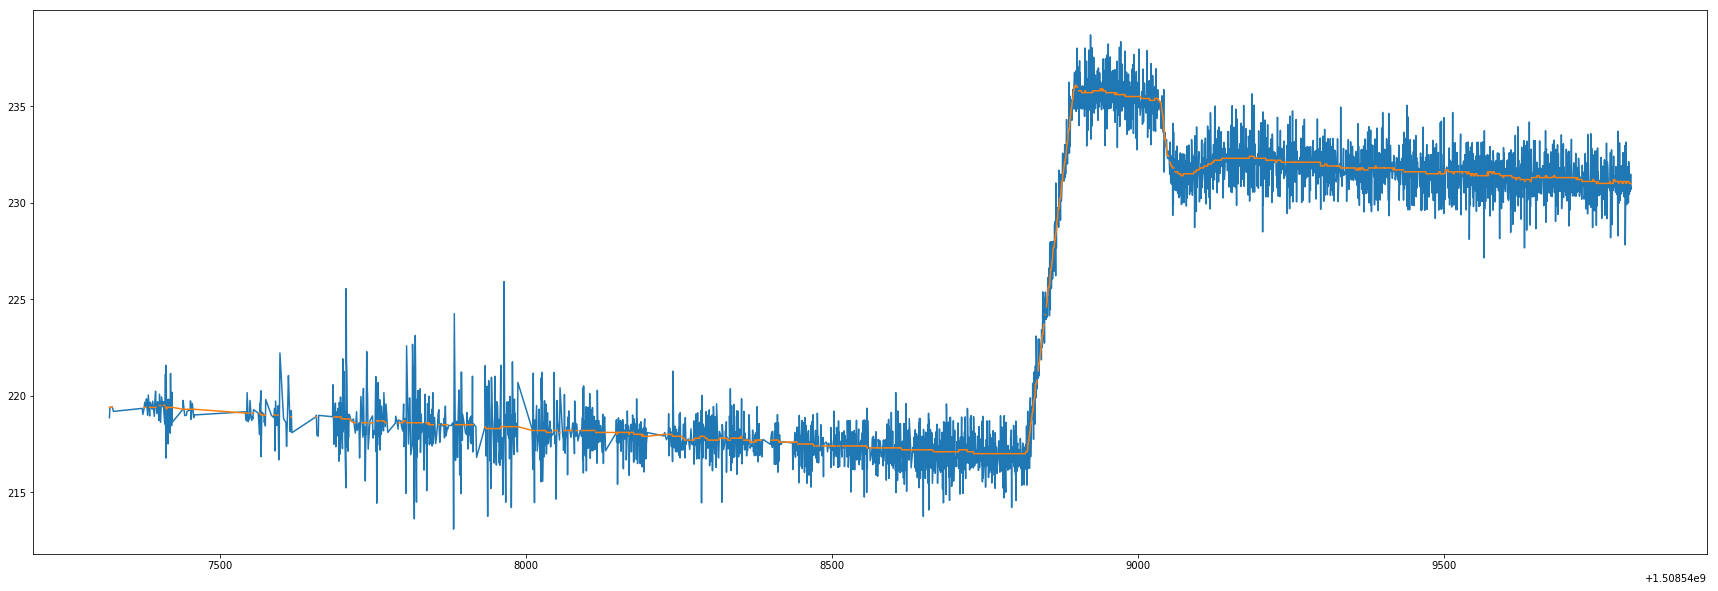

In [38]:
plt.figure(figsize=(30,10))
plt.plot(flight_dict_2['394A07-1']['flight_data']['ts'],flight_dict_2['394A07-1']['flight_data']['bearing'])
plt.plot(flight_dict_2['394A07-1']['flight_data']['ts'],flight_dict_2['394A07-1']['flight_data']['hdg'])
plt.show()

In [185]:
tst = flight_dict_2['394A07-1']['flight_data']
tst = nominal_proj(tst)
tst['dist_proj_err'] = tst.apply(calc_dist_err, axis=1)
# tst['proj_dst_err'] = calc_dist(tst)

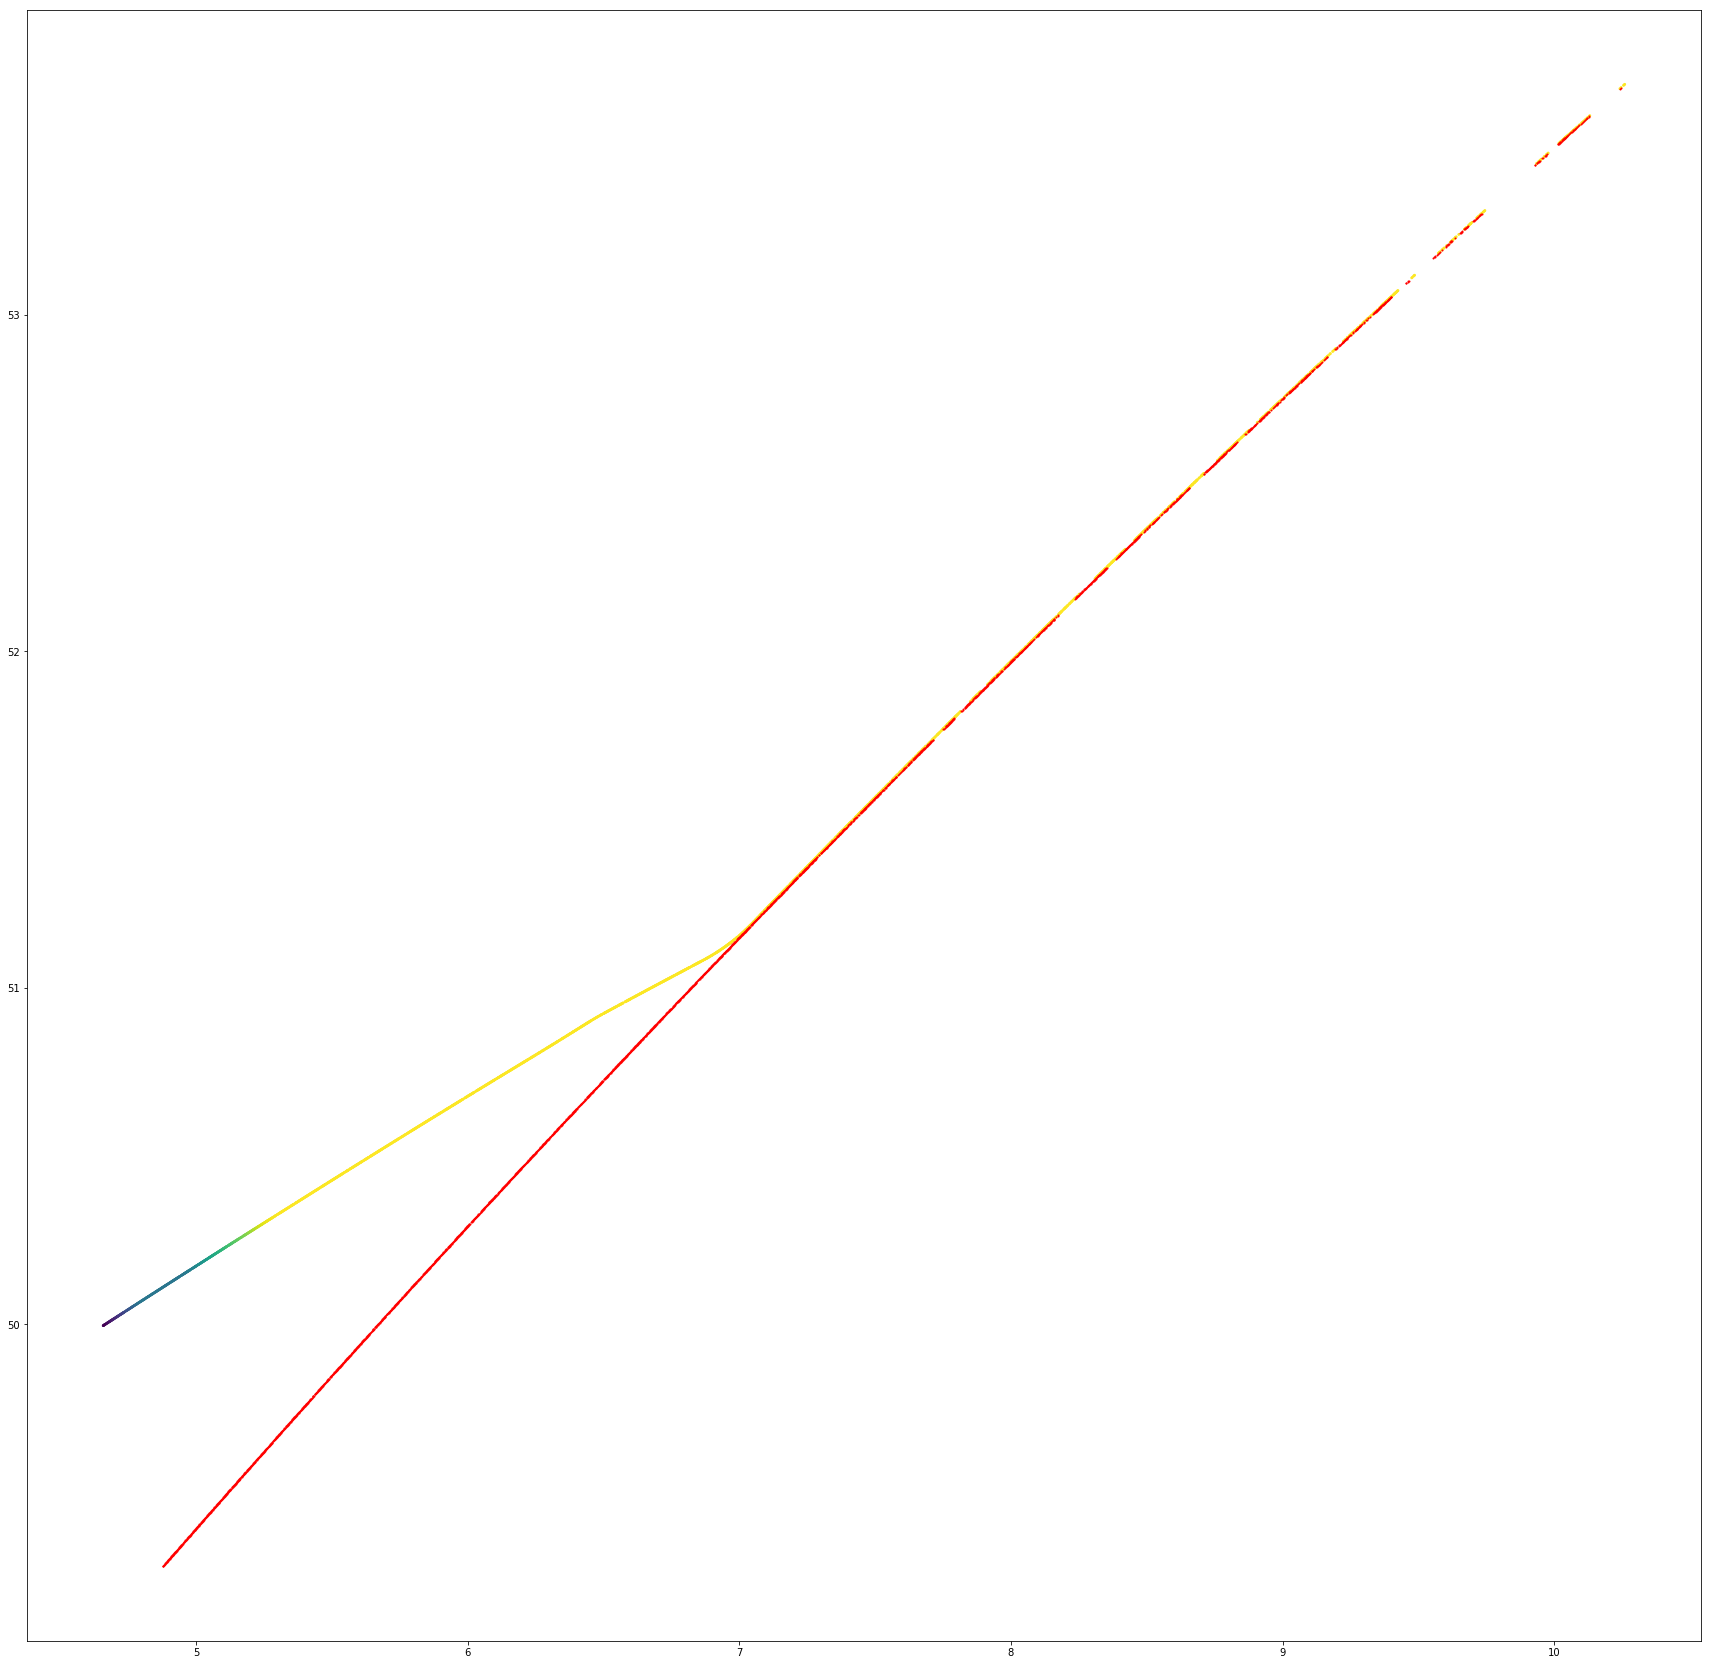

In [156]:
plt.figure(figsize=(30,30))
plt.scatter(tst['lon'],tst['lat'], c=tst['alt'], s=3)
plt.scatter(tst['proj_lon'],tst['proj_lat'], c='r', s=1)
plt.show()

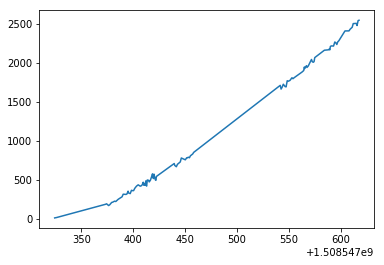

In [186]:
plt.plot(tst['ts'],tst['dist_proj_err'])
plt.show()